# Notebook 04 - Modelling

## Summary

In this notebook, I have trained 4 machine learning models - Logistic Regression, Random Forest, Gradient Boosting, and XGBoost.

I compare their performances using AUC scores, and find that **Gradient Boosting** is the best model among them.

2 extra features are added to try to improve the Gradient Boosting model - *Purchase Price to Premium Ratio*, *Age of Appliance to Manufacturer Guarantee Ratio*.

The most important feature is `AgeApplianceDays`, according to the model.

What-If Analysis:

According to the model, if there is a 10% increase in premium, there would be a 5.55% drop in the conversion rate, leading to a new predicted conversion rate of 28.54%.

---

# Imports

In [6]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import PartialDependenceDisplay

import joblib

import warnings
warnings.filterwarnings("ignore")

---

# Data Preparation

In [7]:
file_path = '/Users/jonwfyeung/Downloads/domestic-and-general'

In [8]:
df_test_cleaned = pd.read_csv(file_path + '/data/df_test_cleaned.csv')
df_test_cleaned.head().T

,0,1,2,3,4
Acc,0,1,0,1,1
ApplianceCode,38,67,38,38,3
ClaimAmount5YearTotal,0.0,105.48,0.0,0.0,9.28
ClaimPast5YearCount,0,2,0,0,1
ClaimsToPlansRatio,0.0,0.25,0.0,0.0,0.0
ClientAccountDesc,4,4,4,4,4
CurrentDate,2024-02-05,2023-09-20,2023-07-29,2023-10-27,2023-02-06
DNISCode,CQ9R1,RR3A1,SQ9R1,CQ9R1,RR1K1
Fee,114.0,150.0,114.0,86.28,103.2
ManufacturerBrandCode,233,135,128,261,46


The following features are chosen for modelling, as they seem relevant or may have significant impact on the probability of customers accepting an offer:
- `ClaimAmount5YearTotal`
- `ClaimsToPlansRatio`
- `PlanLiveCount`
- `PlansAcceptedPast5YearCount`
- `Premium`
- `PriceDiff`
- `ManufacturerGuaranteePartsMonths`
- `PurchasePrice`
- `AgeApplianceDays`
- `RelFee`
- `SchemeTypeName`
- `ApplianceCode`
- `DNISCode`

Reasons for not including the following features in the dataset:

Collinearity with other features
- `ClaimsPast5YearCount`: it has high correlation with `ClaimAmount5YearTotal`; I choose to include `ClaimAmount5YearTotal` as it has more granularity
- `PlansCancelledPast5YearCount`: it has high correlation with `PlansAcceptedPast5YearCount`
- `Fee`: it has high correlation with `Premium`; I choose to include `Premium` as it has a more direct impact to customers

Seemingly not relevant to or impactful on the target variable `Acc`
- `OfferPostcodeSector`
- `CurrentDate`

In [20]:
y = df_test_cleaned['Acc']
X = df_test_cleaned[['ClaimAmount5YearTotal',
                     'ClaimsToPlansRatio',
                     'PlanLiveCount',
                     'PlansAcceptedPast5YearCount',
                     'Premium',
                     'PriceDiff',
                     'ManufacturerGuaranteePartsMonths',
                     'PurchasePrice',
                     'AgeApplianceDays',
                     'RelFee',
                     'SchemeTypeName',
                     'ApplianceCode',
                     'DNISCode'
                    ]]

In [21]:
X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.0,105.48,0.0,0.0,9.28
ClaimsToPlansRatio,0.0,0.25,0.0,0.0,0.0
PlanLiveCount,2,3,1,0,1
PlansAcceptedPast5YearCount,2,8,6,0,0
Premium,94.44,136.32,117.72,66.36,97.8
PriceDiff,-0.171579,-0.0912,0.032632,-0.230876,-0.052326
ManufacturerGuaranteePartsMonths,12,120,12,12,12
PurchasePrice,379.0,550.0,500.0,529.0,250.0
AgeApplianceDays,887,1826,1399,122,1280
RelFee,0.300792,0.294545,0.228,0.1631,0.4128


In [22]:
X['ApplianceCode'] = X['ApplianceCode'].astype("string")
X['SchemeTypeName'] = X['SchemeTypeName'].astype("string")
X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.0,105.48,0.0,0.0,9.28
ClaimsToPlansRatio,0.0,0.25,0.0,0.0,0.0
PlanLiveCount,2,3,1,0,1
PlansAcceptedPast5YearCount,2,8,6,0,0
Premium,94.44,136.32,117.72,66.36,97.8
PriceDiff,-0.171579,-0.0912,0.032632,-0.230876,-0.052326
ManufacturerGuaranteePartsMonths,12,120,12,12,12
PurchasePrice,379.0,550.0,500.0,529.0,250.0
AgeApplianceDays,887,1826,1399,122,1280
RelFee,0.300792,0.294545,0.228,0.1631,0.4128


As there are categorical variables such as `SchemeTypeName`, `ApplianceCode` and `DNISCode`, we have to one-hot encode them before we can put the dataset into modelling.

In [23]:
# drop the first column to avoid collinearity
ohe_scheme = OneHotEncoder(drop='first')

encoded_scheme = ohe_scheme.fit_transform(X[['SchemeTypeName']])
df_encoded_scheme = pd.DataFrame(encoded_scheme.toarray(),
                                 columns=ohe_scheme.categories_[0][1:],
                                 dtype=int
                                 )
df_encoded_scheme.rename(columns={str(i): f"Scheme_{i}" for i in range(1,7)},
                         inplace=True)

df_encoded_scheme.head()

,Scheme_1,Scheme_2,Scheme_3,Scheme_4,Scheme_5,Scheme_6
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,1,0


In [24]:
df_encoded_scheme.shape

(8150, 6)

In [25]:
# drop the first column to avoid collinearity
ohe_appcode = OneHotEncoder(drop='first')

encoded_appcode = ohe_appcode.fit_transform(X[['ApplianceCode']])
df_encoded_appcode = pd.DataFrame(encoded_appcode.toarray(),
                                  columns=ohe_appcode.categories_[0][1:],
                                  dtype=int
                                 )
df_encoded_appcode.rename(columns={str(i): f"AppCode_{i:02d}"\
                                   for i in np.sort(df_test_cleaned['ApplianceCode'].unique())},
                          inplace=True)
df_encoded_appcode.sort_index(axis=1, inplace=True)

df_encoded_appcode.head().T

,0,1,2,3,4
AppCode_02,0,0,0,0,0
AppCode_03,0,0,0,0,1
AppCode_04,0,0,0,0,0
AppCode_05,0,0,0,0,0
AppCode_06,0,0,0,0,0
AppCode_07,0,0,0,0,0
AppCode_08,0,0,0,0,0
AppCode_09,0,0,0,0,0
AppCode_11,0,0,0,0,0
AppCode_12,0,0,0,0,0


In [26]:
df_encoded_appcode.shape

(8150, 49)

In [27]:
# drop the first column to avoid collinearity
ohe_dniscode = OneHotEncoder(drop='first')

encoded_dniscode = ohe_dniscode.fit_transform(X[['DNISCode']])
df_encoded_dniscode = pd.DataFrame(encoded_dniscode.toarray(),
                                   columns=ohe_dniscode.categories_[0][1:],
                                   dtype=int
                                  )

df_encoded_dniscode.head().T

,0,1,2,3,4
CQ0Y1,0,0,0,0,0
CQ2M1,0,0,0,0,0
CQ2Z1,0,0,0,0,0
CQ4Q1,0,0,0,0,0
CQ9J1,0,0,0,0,0
...,...,...,...,...,...
SQ9X1,0,0,0,0,0
SQD81,0,0,0,0,0
SSA21,0,0,0,0,0
TQ0C1,0,0,0,0,0


In [28]:
df_encoded_dniscode.shape

(8150, 76)

In [29]:
X = X.drop(columns=['SchemeTypeName', 'ApplianceCode', 'DNISCode'])
X = pd.concat([X, df_encoded_scheme], axis=1)
X = pd.concat([X, df_encoded_appcode], axis=1)
X = pd.concat([X, df_encoded_dniscode], axis=1)

In [30]:
X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.00,105.48,0.00,0.00,9.28
ClaimsToPlansRatio,0.00,0.25,0.00,0.00,0.00
PlanLiveCount,2.00,3.00,1.00,0.00,1.00
PlansAcceptedPast5YearCount,2.00,8.00,6.00,0.00,0.00
Premium,94.44,136.32,117.72,66.36,97.80
...,...,...,...,...,...
SQ9X1,0.00,0.00,0.00,0.00,0.00
SQD81,0.00,0.00,0.00,0.00,0.00
SSA21,0.00,0.00,0.00,0.00,0.00
TQ0C1,0.00,0.00,0.00,0.00,0.00


In [31]:
X.columns

Index(['ClaimAmount5YearTotal', 'ClaimsToPlansRatio', 'PlanLiveCount',
       'PlansAcceptedPast5YearCount', 'Premium', 'PriceDiff',
       'ManufacturerGuaranteePartsMonths', 'PurchasePrice', 'AgeApplianceDays',
       'RelFee',
       ...
       'SQ4A1', 'SQ4Q1', 'SQ661', 'SQ9J1', 'SQ9R1', 'SQ9X1', 'SQD81', 'SSA21',
       'TQ0C1', 'TQ9R1'],
      dtype='object', length=141)

In [32]:
print(y.shape)
print(X.shape)

(8150,)
(8150, 141)


## Train-Test Split

Training set: 80% of the data
Test set: 20% of the data

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [212]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6520, 141)
(1630, 141)
(6520,)
(1630,)


## Scaling

Standard scaling is used here.

In [213]:
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

# Modelling

Here, I intend to train 4 machine learning models - Logistic Regression, Random Forest, Gradient Boosting, and XGBoost - and compare their performance to find out the best one for prediction and analysis.

## Logistic Regression

In [214]:
logreg = LogisticRegression(penalty='l2', max_iter=1000, C=0.1)

logreg.fit(X_train_s, y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [215]:
y_logreg_pred = logreg.predict(X_test_s)

y_logreg_proba_train = logreg.predict_proba(X_train_s)[:, 1]
y_logreg_proba_test = logreg.predict_proba(X_test_s)[:, 1]

### Evaluation

We can have an overview of the performance of the model here with:
- Accuracy score
- Confusion matrix
- Classification report
- ROC curve and AUC score

This is for a quick understanding of the model. We will have a comparison of the models later below.

Accuracy score on train: 0.7498
Accuracy score on test: 0.7393


Confusion Matrix (proportion):


<Figure size 640x480 with 0 Axes>

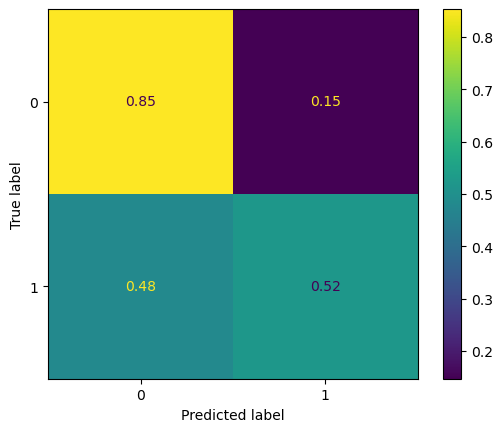


Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1074
           1       0.65      0.52      0.58       556

    accuracy                           0.74      1630
   macro avg       0.71      0.69      0.69      1630
weighted avg       0.73      0.74      0.73      1630


AUC: 



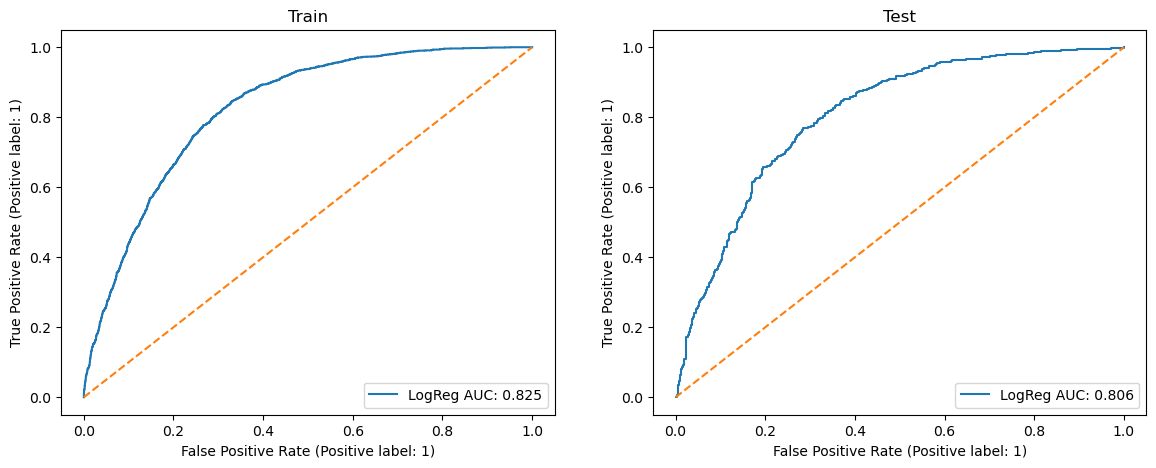

In [216]:
print_line = "\n=======================================================\n"
model = logreg

# accuracy score
print(f"Accuracy score on train: {model.score(X_train_s, y_train):.4f}")
print(f"Accuracy score on test: {model.score(X_test_s, y_test):.4f}")


# confusion matrix
print(print_line)
print("Confusion Matrix (proportion):")
plt.figure()
ConfusionMatrixDisplay.from_estimator(model, X_test_s, y_test, normalize='true')
plt.show()


# classification report
print("\nClassification Report:", print_line, classification_report(y_test, y_logreg_pred))


# AUC - Area Under ROC Curve
print("\nAUC:", print_line)
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

auc_train = round(roc_auc_score(y_train, y_logreg_proba_train), 3)
auc_test = round(roc_auc_score(y_test, y_logreg_proba_test), 3)

RocCurveDisplay.from_estimator(model, X_train_s, y_train,
                               ax = axes[0], label = f"LogReg AUC: {auc_train}")
RocCurveDisplay.from_estimator(model, X_test_s, y_test,
                               ax = axes[1], label = f"LogReg AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

plt.show()

## Random Forest

In [217]:
rfc = RandomForestClassifier(random_state=1)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [218]:
y_rfc_pred = rfc.predict(X_test)

y_rfc_proba_train = rfc.predict_proba(X_train)[:, 1]
y_rfc_proba_test = rfc.predict_proba(X_test)[:, 1]

### Evaluation

Accuracy score on train: 1.0000
Accuracy score on test: 0.7595


Confusion Matrix (proportion):


<Figure size 640x480 with 0 Axes>

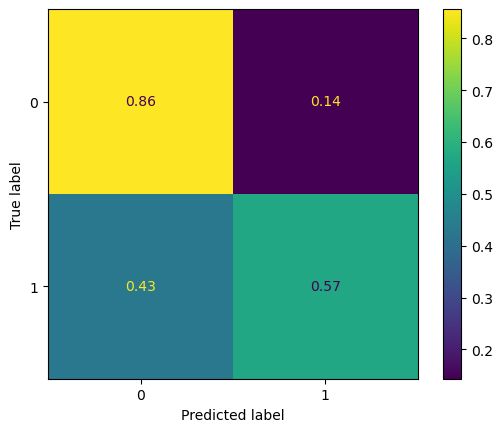


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      1074
           1       0.67      0.57      0.62       556

    accuracy                           0.76      1630
   macro avg       0.73      0.71      0.72      1630
weighted avg       0.75      0.76      0.75      1630


AUC: 



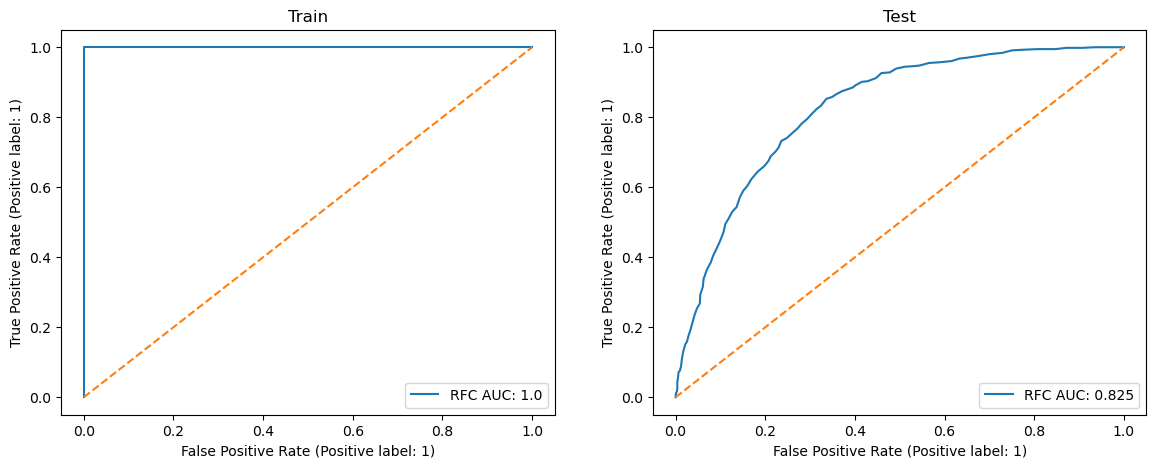

In [220]:
print_line = "\n=======================================================\n"
model = rfc

# accuracy score
print(f"Accuracy score on train: {model.score(X_train, y_train):.4f}")
print(f"Accuracy score on test: {model.score(X_test, y_test):.4f}")


# confusion matrix
print(print_line)
print("Confusion Matrix (proportion):")
plt.figure()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')
plt.show()


# classification report
print("\nClassification Report:", print_line, classification_report(y_test, y_rfc_pred))


# AUC - Area Under ROC Curve
print("\nAUC:", print_line)
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

auc_train = round(roc_auc_score(y_train, y_rfc_proba_train), 3)
auc_test = round(roc_auc_score(y_test, y_rfc_proba_test), 3)

RocCurveDisplay.from_estimator(model, X_train, y_train, ax = axes[0], label = f"RFC AUC: {auc_train}")
RocCurveDisplay.from_estimator(model, X_test, y_test, ax = axes[1], label = f"RFC AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

plt.show()

## Gradient Boosting

In [224]:
gbc = GradientBoostingClassifier(random_state=1)

gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

In [225]:
y_gbc_pred = gbc.predict(X_test)

y_gbc_proba_train = gbc.predict_proba(X_train)[:, 1]
y_gbc_proba_test = gbc.predict_proba(X_test)[:, 1]

### Evaluation

Accuracy score on train: 0.7860
Accuracy score on test: 0.7546


Confusion Matrix (proportion):


<Figure size 640x480 with 0 Axes>

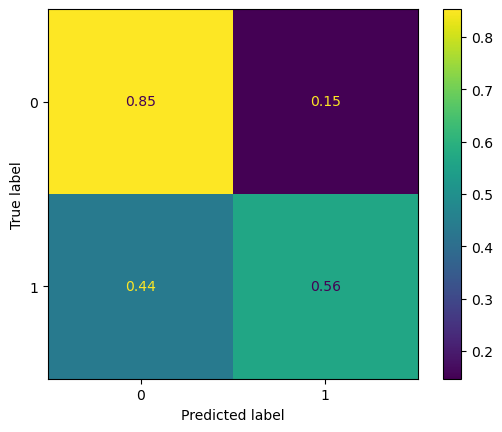


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1074
           1       0.67      0.56      0.61       556

    accuracy                           0.75      1630
   macro avg       0.73      0.71      0.72      1630
weighted avg       0.75      0.75      0.75      1630


AUC: 



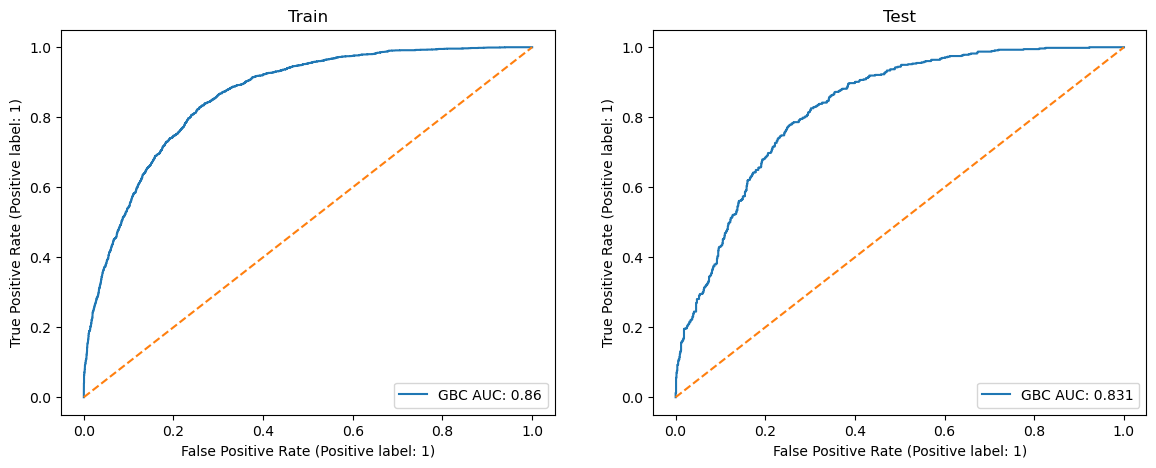

In [226]:
print_line = "\n=======================================================\n"
model = gbc

# accuracy score
print(f"Accuracy score on train: {model.score(X_train, y_train):.4f}")
print(f"Accuracy score on test: {model.score(X_test, y_test):.4f}")


# confusion matrix
print(print_line)
print("Confusion Matrix (proportion):")
plt.figure()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')
plt.show()


# classification report
print("\nClassification Report:", print_line, classification_report(y_test, y_gbc_pred))


# AUC - Area Under ROC Curve
print("\nAUC:", print_line)
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

auc_train = round(roc_auc_score(y_train, y_gbc_proba_train), 3)
auc_test = round(roc_auc_score(y_test, y_gbc_proba_test), 3)

RocCurveDisplay.from_estimator(model, X_train, y_train, ax = axes[0], label = f"GBC AUC: {auc_train}")
RocCurveDisplay.from_estimator(model, X_test, y_test, ax = axes[1], label = f"GBC AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

plt.show()

## XGBoost

In [227]:
xgbc = XGBClassifier(random_state=1)

xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [228]:
y_xgbc_pred = xgbc.predict(X_test)

y_xgbc_proba_train = xgbc.predict_proba(X_train)[:, 1]
y_xgbc_proba_test = xgbc.predict_proba(X_test)[:, 1]

### Evaluation

Accuracy score on train: 0.9521
Accuracy score on test: 0.7448


Confusion Matrix (proportion):


<Figure size 640x480 with 0 Axes>

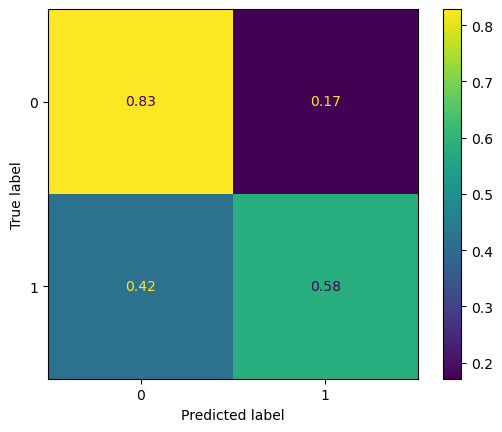


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1074
           1       0.64      0.58      0.61       556

    accuracy                           0.74      1630
   macro avg       0.72      0.71      0.71      1630
weighted avg       0.74      0.74      0.74      1630


AUC: 



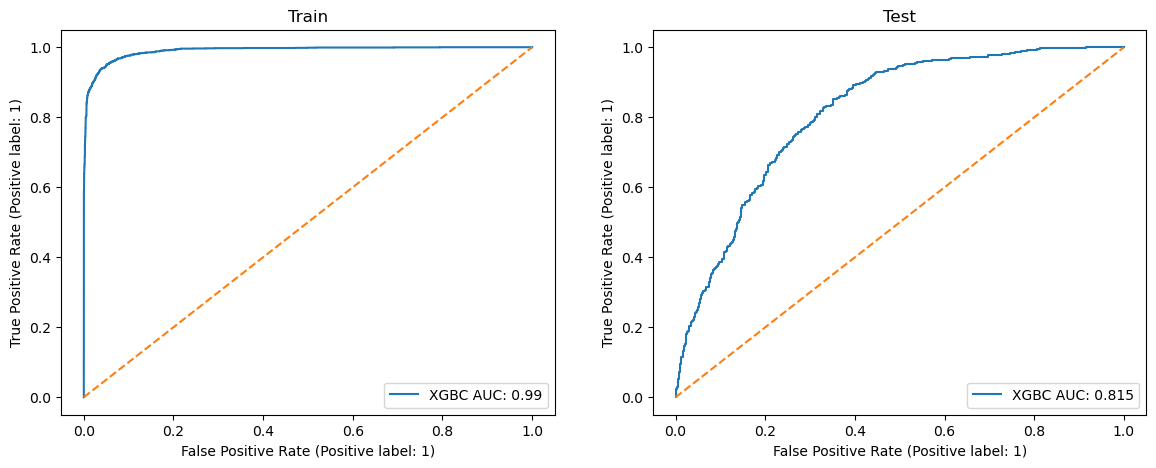

In [229]:
print_line = "\n=======================================================\n"
model = xgbc

# accuracy score
print(f"Accuracy score on train: {model.score(X_train, y_train):.4f}")
print(f"Accuracy score on test: {model.score(X_test, y_test):.4f}")


# confusion matrix
print(print_line)
print("Confusion Matrix (proportion):")
plt.figure()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')
plt.show()


# classification report
print("\nClassification Report:", print_line, classification_report(y_test, y_xgbc_pred))


# AUC - Area Under ROC Curve
print("\nAUC:", print_line)
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

auc_train = round(roc_auc_score(y_train, y_xgbc_proba_train), 3)
auc_test = round(roc_auc_score(y_test, y_xgbc_proba_test), 3)

RocCurveDisplay.from_estimator(model, X_train, y_train, ax = axes[0], label = f"XGBC AUC: {auc_train}")
RocCurveDisplay.from_estimator(model, X_test, y_test, ax = axes[1], label = f"XGBC AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

plt.show()

In [271]:
# # saving the models
# joblib.dump(logreg, file_path + '/model/logreg.pkl')
# joblib.dump(rfc, file_path + '/model/rfc.pkl')
# joblib.dump(gbc, file_path + '/model/gbc.pkl')
# joblib.dump(xgbc, file_path + '/model/xgbc.pkl')

In [272]:
# # uncomment this cell and load the models here
# logreg = joblib.load(file_path + '/model/logreg.pkl')
# rfc = joblib.load(file_path + '/model/rfc.pkl')
# gbc = joblib.load(file_path + '/model/gbc.pkl')
# xgbc = joblib.load(file_path + '/model/xgbc.pkl')

## Hyperparameter Tuning

The above models could be improved by tuning their hyperparameters.

One common approach is to carry out Grid Search cross-validations with GridSearchCV and do it in the Coarse-to-Fine manner, i.e. we can start with a sparse grid search on a wide range first, and then reiterate grid searches on places where the performance seems better. This process involves cross-validations and hence we need to split the original dataset into 3 subsets then - one for training set, one for validation set, and one for test set.

Some common hyperparameters as follows can be tuned:
- Logistic Regression: C, max_iter
- Random Forest: n_estimators, max_depth, min_sample_leaf
- Gradient Boosting: n_estimators, max_depth, learning_rate
- XGBoost: n_estimators, max_depth, learning_rate

# Comparing The Models

As noticed before in the EDA section, there is some degree of class imbalance of the target variable `Acc` (66% of '0' vs 34% of '1').

Using the accuracy score might not have an adequately clear measurement of how well the model could pick up the positive targets.

Meanwhile, the model is to understand the demand of the market. The acceptance and the rejection of price offers are equally important in the modelling. Therefore, I think AUC score would be a suitable choice of metric for the evaluations of the models.

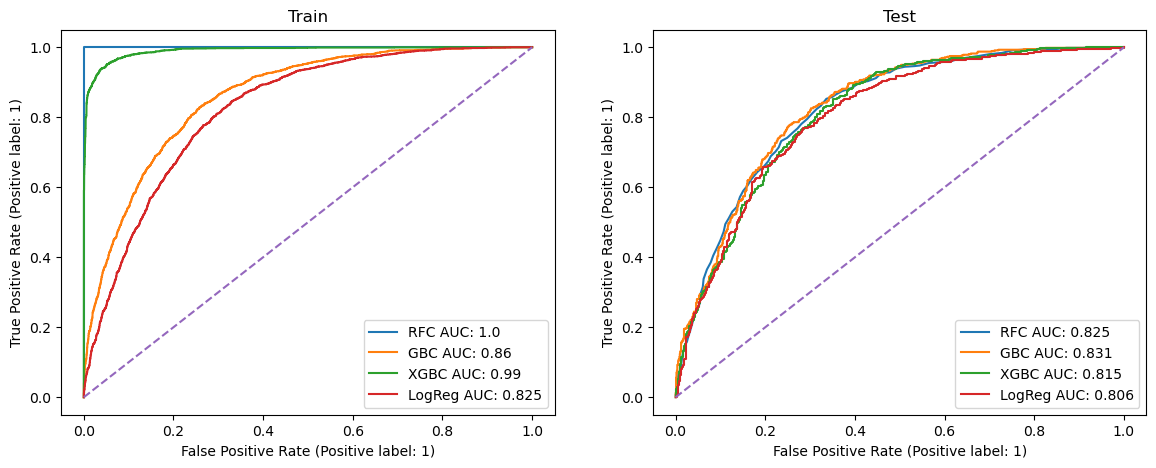

In [267]:
# All model candidates
models = [
    rfc,
    gbc,
    xgbc
]

models_name = ['RFC', 'GBC', 'XGBC']

# ROC curves and AUC scores - Random Forest, Gradient Boosting, XGBoost
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

for i in range(len(models)):
    
    y_proba_train = models[i].predict_proba(X_train)[:, 1]
    y_proba_test = models[i].predict_proba(X_test)[:, 1]
    
    auc_train = round(roc_auc_score(y_train, y_proba_train), 3)
    auc_test = round(roc_auc_score(y_test, y_proba_test), 3)
    
    RocCurveDisplay.from_estimator(models[i], X_train, y_train, ax = axes[0], label = f"{models_name[i]} AUC: {auc_train}")
    RocCurveDisplay.from_estimator(models[i], X_test, y_test, ax = axes[1], label = f"{models_name[i]} AUC: {auc_test}")

# ROC curves and AUC scores - Logistic Regression
auc_train = round(roc_auc_score(y_train, y_logreg_proba_train), 3)
auc_test = round(roc_auc_score(y_test, y_logreg_proba_test), 3)

RocCurveDisplay.from_estimator(logreg, X_train_s, y_train,
                               ax = axes[0], label = f"LogReg AUC: {auc_train}")
RocCurveDisplay.from_estimator(logreg, X_test_s, y_test,
                               ax = axes[1], label = f"LogReg AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title('Test')

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

Among the models, **Gradient Boosting Classifier** has the best performance on the AUC score (0.831).

Let's check the top 15 important features analyzed from the model so far.

In [232]:
gbc_features = pd.DataFrame({
                            'feature': gbc.feature_names_in_,
                            'importance': gbc.feature_importances_
                            })
gbc_features.sort_values(by='importance', ascending=False, ignore_index=True, inplace=True)

gbc_features.head(15)

,feature,importance
0,AgeApplianceDays,0.235744
1,PriceDiff,0.172437
2,PlansAcceptedPast5YearCount,0.092258
3,AppCode_38,0.089730
4,Scheme_6,0.075597
5,Premium,0.064872
6,Scheme_3,0.062830
7,RR4Q1,0.039746
8,QQ9R1,0.029675
9,RelFee,0.018477


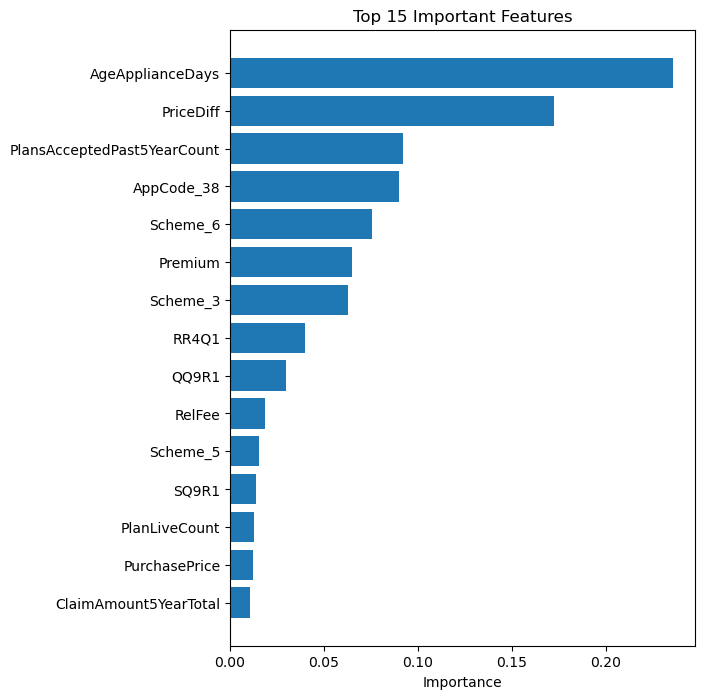

In [233]:
plt.figure(figsize=(6,8))
plt.barh(gbc_features.iloc[:15,:].sort_values(by='importance')['feature'],
         gbc_features.iloc[:15,:].sort_values(by='importance')['importance'])
plt.xlabel("Importance")
plt.title("Top 15 Important Features")
plt.show()

---

# Adding Features

Now I intend to add the following 2 features and try to see if they could improve the performance of the model.
- Purchase Price / Premium

The ratio of Purchase Price of the appliance to the Premium might be a common concern of customers when they consider if they should accept a price offer.

- Age Appliance Days / Manufacturer Guarantee Parts Months

As the age of the appliance grows and eventually goes beyond the guarantee duration, the customers might become more and more likely to consider a price offer.

In [33]:
X['PurchaseToPremiumRatio'] = X['PurchasePrice'] / X['Premium']
X['AgeToGuaranteeRatio'] = X['AgeApplianceDays'] / X['ManufacturerGuaranteePartsMonths']
X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.000000,105.480000,0.000000,0.000000,9.280000
ClaimsToPlansRatio,0.000000,0.250000,0.000000,0.000000,0.000000
PlanLiveCount,2.000000,3.000000,1.000000,0.000000,1.000000
PlansAcceptedPast5YearCount,2.000000,8.000000,6.000000,0.000000,0.000000
Premium,94.440000,136.320000,117.720000,66.360000,97.800000
...,...,...,...,...,...
SSA21,0.000000,0.000000,0.000000,0.000000,0.000000
TQ0C1,0.000000,0.000000,0.000000,0.000000,0.000000
TQ9R1,0.000000,0.000000,0.000000,0.000000,0.000000
PurchaseToPremiumRatio,4.013130,4.034624,4.247367,7.971670,2.556237


In [34]:
X[['PurchaseToPremiumRatio', 'AgeToGuaranteeRatio']].isna().sum()

PurchaseToPremiumRatio    0
AgeToGuaranteeRatio       0
dtype: int64

In [35]:
print(y.shape)
print(X.shape)

(8150,)
(8150, 143)


## Train-Test Split

Training set: 80% of the data
Test set: 20% of the data

In [237]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [238]:
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(6520, 143)
(1630, 143)
(6520,)
(1630,)


# Modelling

Here I use the best model Gradient Boosting, as suggested above.

## Gradient Boosting

In [239]:
gbc2 = GradientBoostingClassifier(random_state=1)

gbc2.fit(X_train2, y_train2)

GradientBoostingClassifier(random_state=1)

In [269]:
# # saving the model to 'gbc2.pkl'
# joblib.dump(gbc2, file_path + '/model/gbc2.pkl')

In [270]:
# # uncomment this cell and load the model from 'gbc2.pkl' here
# gbc2 = joblib.load(file_path + '/model/gbc2.pkl')

In [242]:
y_gbc_pred2 = gbc2.predict(X_test2)

y_gbc_proba_train2 = gbc2.predict_proba(X_train2)[:, 1]
y_gbc_proba_test2 = gbc2.predict_proba(X_test2)[:, 1]

## Evaluation

Accuracy score on train: 0.7853
Accuracy score on test: 0.7595


Confusion Matrix (proportion):


<Figure size 640x480 with 0 Axes>

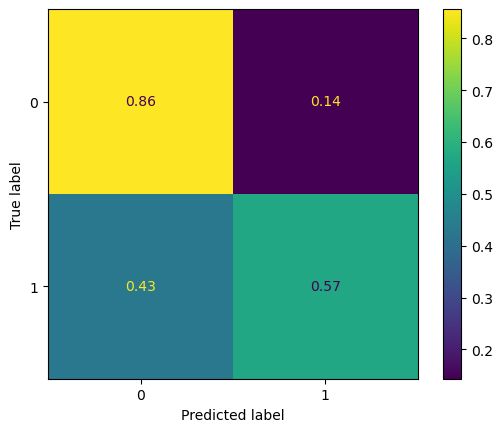


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      1074
           1       0.67      0.57      0.62       556

    accuracy                           0.76      1630
   macro avg       0.73      0.71      0.72      1630
weighted avg       0.75      0.76      0.75      1630


AUC: 



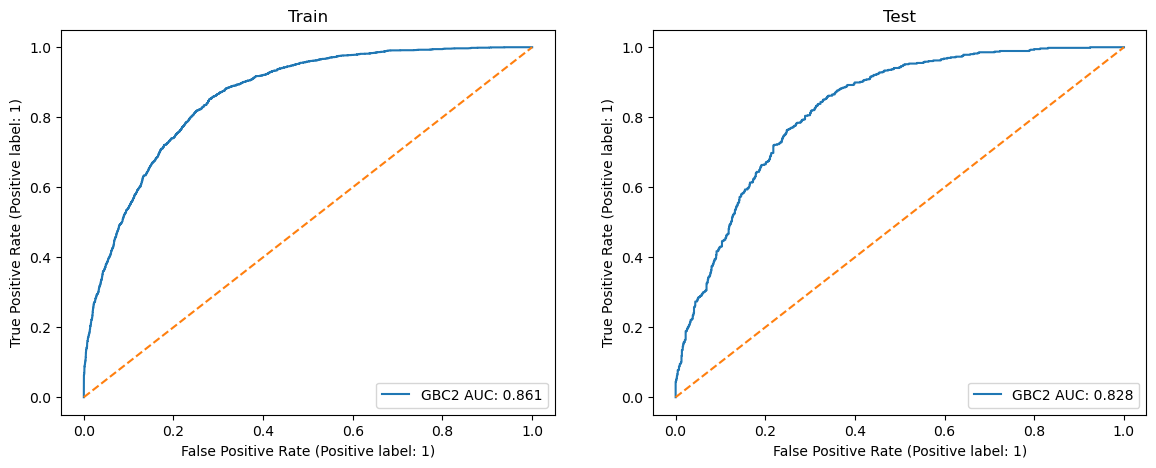

In [243]:
print_line = "\n=======================================================\n"
model = gbc2

# accuracy score
print(f"Accuracy score on train: {model.score(X_train2, y_train2):.4f}")
print(f"Accuracy score on test: {model.score(X_test2, y_test2):.4f}")


# confusion matrix
print(print_line)
print("Confusion Matrix (proportion):")
plt.figure()
ConfusionMatrixDisplay.from_estimator(model, X_test2, y_test2, normalize='true')
plt.show()


# classification report
print("\nClassification Report:", print_line, classification_report(y_test2, y_gbc_pred2))


# AUC - Area Under ROC Curve
print("\nAUC:", print_line)
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

auc_train = round(roc_auc_score(y_train2, y_gbc_proba_train2), 3)
auc_test = round(roc_auc_score(y_test2, y_gbc_proba_test2), 3)

RocCurveDisplay.from_estimator(model, X_train2, y_train2, ax = axes[0], label = f"GBC2 AUC: {auc_train}")
RocCurveDisplay.from_estimator(model, X_test2, y_test2, ax = axes[1], label = f"GBC2 AUC: {auc_test}")

axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].plot([0,1], [0,1], linestyle='--')
axes[1].plot([0,1], [0,1], linestyle='--')

plt.show()

Sadly, the AUC score is 0.828, which is slightly lower than the AUC score (0.831) of the previous Gradient Boosting model.

The accuracy improves slightly though. It is 0.7595, an increase from the accuracy score of 0.7546 from the previous Gradient Boosting model.

The recall for class '1' does improve slightly also, from 0.56 to 0.57.

---

# Feature Interpretation

## Feature Importances

According to the second Gradient Boosting model, the top 15 important features are as follows:

In [245]:
gbc2_features = pd.DataFrame({
                             'feature': gbc2.feature_names_in_,
                             'importance': gbc2.feature_importances_
                             })
gbc2_features.sort_values(by='importance', ascending=False, ignore_index=True, inplace=True)

gbc2_features.head(15)

,feature,importance
0,AgeApplianceDays,0.217990
1,PriceDiff,0.164739
2,AppCode_38,0.095975
3,PlansAcceptedPast5YearCount,0.089590
4,Premium,0.070276
5,Scheme_6,0.068804
6,Scheme_3,0.063967
7,RR4Q1,0.038056
8,QQ9R1,0.027927
9,AgeToGuaranteeRatio,0.021592


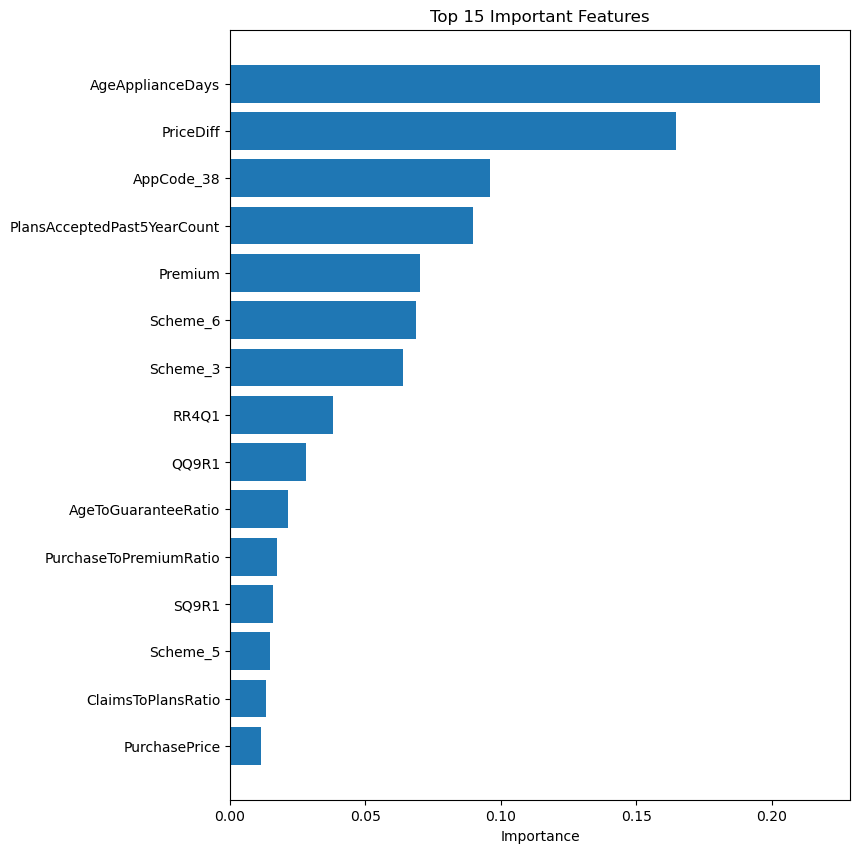

In [246]:
plt.figure(figsize=(8,10))
plt.barh(gbc2_features.iloc[:15,:].sort_values(by='importance')['feature'],
         gbc2_features.iloc[:15,:].sort_values(by='importance')['importance'])
plt.xlabel("Importance")
plt.title("Top 15 Important Features")
plt.show()

The top 5 most important features are:
- `AgeApplianceDays`
- `PriceDiff`
- `AppCode_38`
- `PlansAcceptedPast5YearCount`
- `Premium`

The newly added features `AgeToGuaranteeRatio` and `PurchaseToPremiumRatio` are ranked 10th and 11th only.

## Partial Dependence Plots

Here, I intend to observe the partial dependence of the top 5 important features using PDP & ICE Plots.

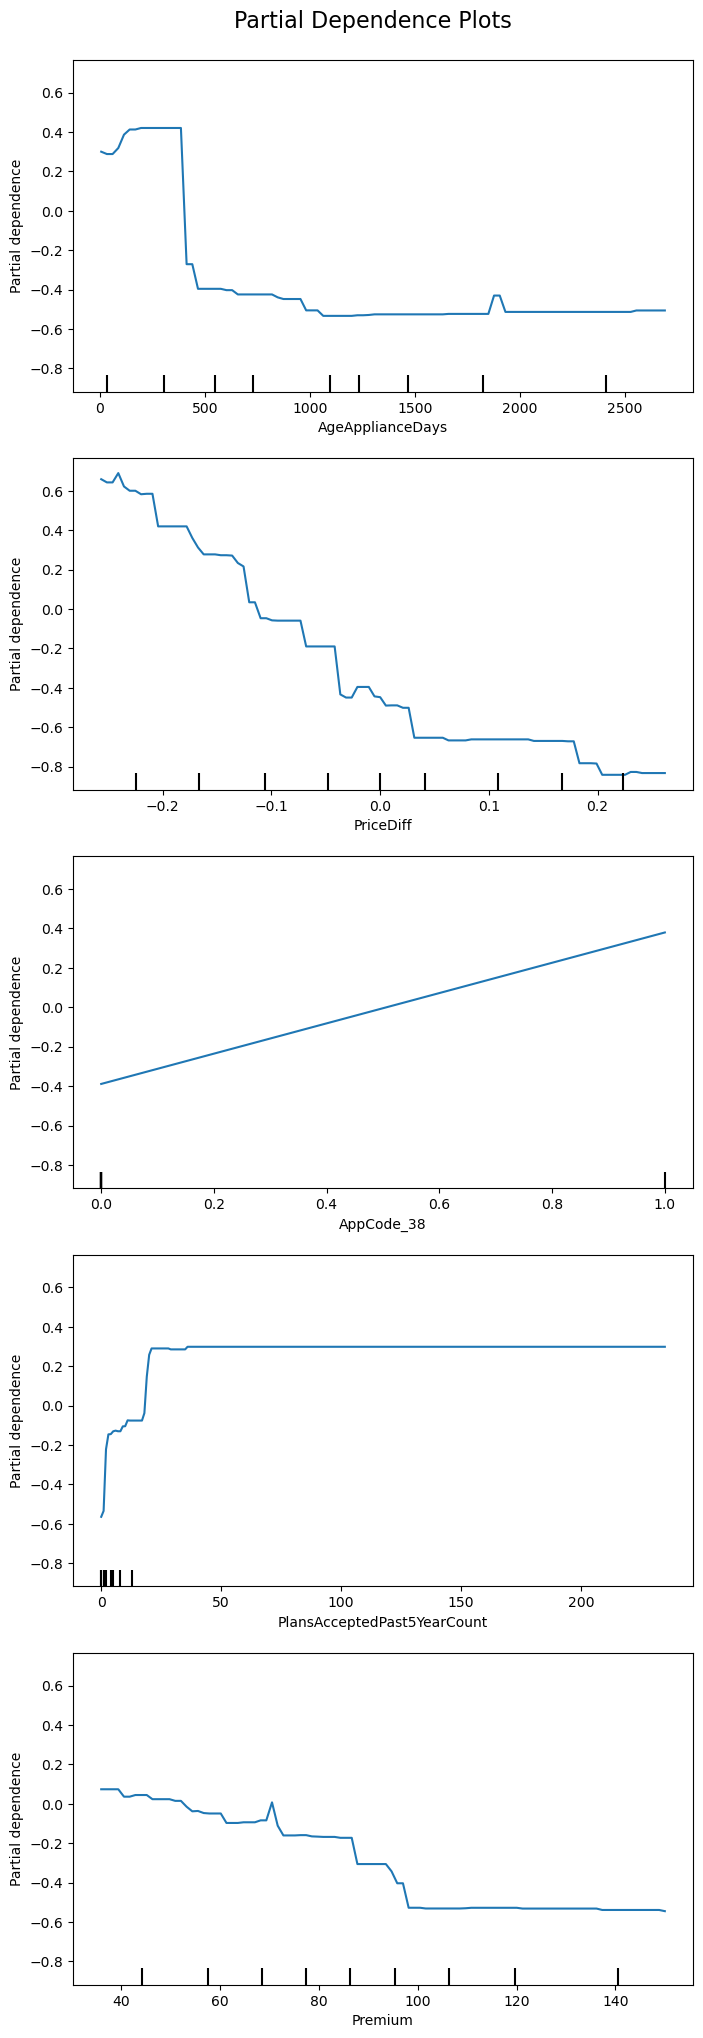

In [247]:
# Partial Dependence Plots
features = [
            "AgeApplianceDays",
            "PriceDiff",
            "AppCode_38",
            "PlansAcceptedPast5YearCount",
            "Premium"
           ]

fig, axs = plt.subplots(5, 1, figsize=(8, 25))
display = PartialDependenceDisplay.from_estimator(
    gbc2,
    X_train2,
    features,
    kind="average",
    random_state=0,
    ax=axs
)
fig.suptitle("Partial Dependence Plots", fontsize=16, y=0.9)
plt.show()

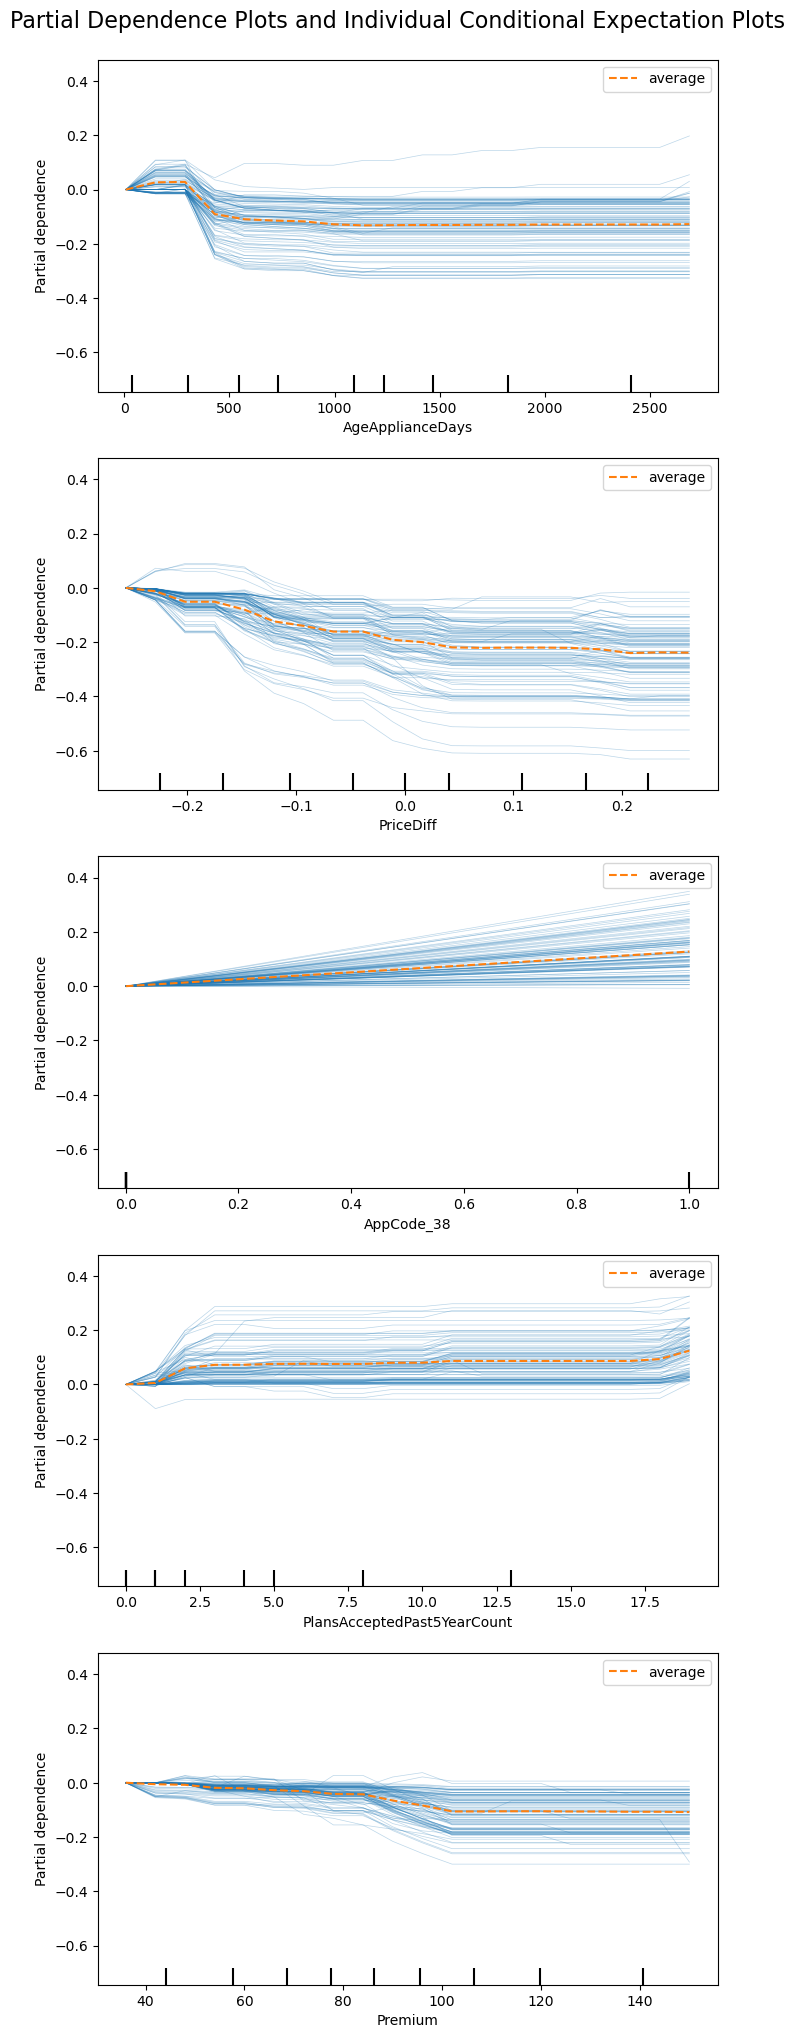

In [248]:
# Partial Dependence Plots and Individual Conditional Expectation Plots
common_params = {
    "subsample": 100,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    "features": features,
    "kind": "both",
    "centered": True
}

fig, axs = plt.subplots(5, 1, figsize=(8, 25))
display = PartialDependenceDisplay.from_estimator(
    gbc2,
    X_train2,
    **features_info,
    ax=axs,
    **common_params
)
fig.suptitle("Partial Dependence Plots and Individual Conditional Expectation Plots", fontsize=16, y=0.9)
plt.show()

According to the feature importances acquired from the Gradient Boosting model, `AgeApplianceDays` is the most important feature.

From the PDP, we can see that the expected probability of acceptance remains at around 0.4 but drops sharply when the age of the appliance enters the zone of 250 to 400 days. This is the theoretical impact of the `AgeApplianceDays` on the probability of acceptance.

The age of the appliance might be a proxy metric for the potential wear and tear of the appliance. Assuming a customer uses the appliance regularly, the condition of the appliance would reasonably deteriorate and it would increase the likelihood of needing a repair or replacement. The manufacturer guarantee would also be more close to expiry or even expire as the appliance gets older. All these might be the reason why `AgeApplianceDays` is the most important feature for customers' demand for appliance cover plans.

---

# What-If Analysis

What would be the impact on conversion if there is a 10% increase on premium?

In [249]:
X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.000000,105.480000,0.000000,0.000000,9.280000
ClaimsToPlansRatio,0.000000,0.250000,0.000000,0.000000,0.000000
PlanLiveCount,2.000000,3.000000,1.000000,0.000000,1.000000
PlansAcceptedPast5YearCount,2.000000,8.000000,6.000000,0.000000,0.000000
Premium,94.440000,136.320000,117.720000,66.360000,97.800000
...,...,...,...,...,...
SSA21,0.000000,0.000000,0.000000,0.000000,0.000000
TQ0C1,0.000000,0.000000,0.000000,0.000000,0.000000
TQ9R1,0.000000,0.000000,0.000000,0.000000,0.000000
PurchaseToPremiumRatio,4.013130,4.034624,4.247367,7.971670,2.556237


In [250]:
# increasing the 'Premium' column by 10%
new_X = X.copy()
new_X['Premium'] = new_X['Premium'] * 1.1
new_X.head().T

,0,1,2,3,4
ClaimAmount5YearTotal,0.000000,105.480000,0.000000,0.000000,9.280000
ClaimsToPlansRatio,0.000000,0.250000,0.000000,0.000000,0.000000
PlanLiveCount,2.000000,3.000000,1.000000,0.000000,1.000000
PlansAcceptedPast5YearCount,2.000000,8.000000,6.000000,0.000000,0.000000
Premium,103.884000,149.952000,129.492000,72.996000,107.580000
...,...,...,...,...,...
SSA21,0.000000,0.000000,0.000000,0.000000,0.000000
TQ0C1,0.000000,0.000000,0.000000,0.000000,0.000000
TQ9R1,0.000000,0.000000,0.000000,0.000000,0.000000
PurchaseToPremiumRatio,4.013130,4.034624,4.247367,7.971670,2.556237


The new predicted demand would be as follows:

In [251]:
new_y_pred = gbc2.predict(new_X)
new_X['Acc'] = new_y_pred
new_X[['Acc']]

,Acc
0,0
1,0
2,0
3,1
4,0
...,...
8145,0
8146,0
8147,0
8148,0


In [252]:
print(f"The new predicted conversion rate: {np.mean(new_y_pred)*100:.2f}%")

The new predicted conversion rate: 28.54%


The original conversion rate in the Price Test dataset is 34.09%.

According to the model, if there is a 10% increase in premium, there would be a 5.55% drop in the conversion rate, leading to a new predicted conversion rate of 28.54%.